In [6]:
# Standard library imports
import os
import json
import random
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Set, Tuple

# Third-party imports
import cv2
import numpy as np
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm
from datasets import Dataset, DatasetDict, load_dataset

import matplotlib.pyplot as plt

In [7]:
#! pip install opencv-python

In [8]:
def analyze_categories(dataset):
    """
    Analyze clothing categories in a fashion dataset.
    
    Args:
        dataset
        
    Returns:
        pd.DataFrame: Statistics for each category
    """
    
    # Get category names from features
    category_names = dataset['train'].features['objects'].feature['category'].names
    
    # Initialize statistics
    stats = defaultdict(lambda: {
        'count': 0,
        'total_area': 0,
        'areas': []
    })
    
    # Process training set
    print("Analyzing object statistics...")
    for item in tqdm(dataset['train']):
        objects = item['objects']
        for cat_id, area in zip(objects['category'], objects['area']):
            cat_name = category_names[cat_id]
            stats[cat_name]['count'] += 1
            stats[cat_name]['total_area'] += area
            stats[cat_name]['areas'].append(area)
    
    # Calculate statistics and create DataFrame
    data = []
    for cat, metrics in stats.items():
        if metrics['count'] > 0:  # Avoid division by zero
            data.append({
                'category': cat,
                'count': metrics['count'],
                'avg_area': metrics['total_area'] / metrics['count'],
                'area_std': np.std(metrics['areas']),
                'is_part': cat.lower() in {'collar', 'pocket', 'sleeve', 
                                         'zipper', 'button', 'buckle'}
            })
    
    df = pd.DataFrame(data)
    
    # Calculate combined score and sort
    df['score'] = df['count'] * df['avg_area']
    df = df.sort_values('score', ascending=False)
    
    # Filter and display main garments
    main_garments = df[~df['is_part']].head(10)
    print("\nTop 10 Main Garments by frequency and size:")
    print(main_garments[['category', 'count', 'avg_area']].round(2).to_string())
    
    # Visualize
    plt.figure(figsize=(15, 6))
    plt.bar(main_garments['category'], main_garments['avg_area'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Average Area by Category')
    plt.ylabel('Average Area (pixels²)')
    plt.tight_layout()
    plt.show()
    
    return df


In [9]:
dataset_name="detection-datasets/fashionpedia"
dataset = load_dataset(dataset_name)
print("Dataset loaded!!")

Dataset loaded!!


Analyzing object statistics...


100%|████████████████████████████████████| 45623/45623 [02:50<00:00, 267.27it/s]



Top 10 Main Garments by frequency and size:
                    category  count   avg_area
2                      dress  18739  115943.69
15  top, t-shirt, sweatshirt  16548   85750.85
13                    jacket   7833  103959.60
14                     pants  12414   51118.22
11             shirt, blouse   6161   75796.63
26                      coat   3124  123159.93
31                     skirt   5046   64093.61
3                    sweater   1494  184520.64
36                  cardigan   1107  131173.24
0                       shoe  46374    2929.90


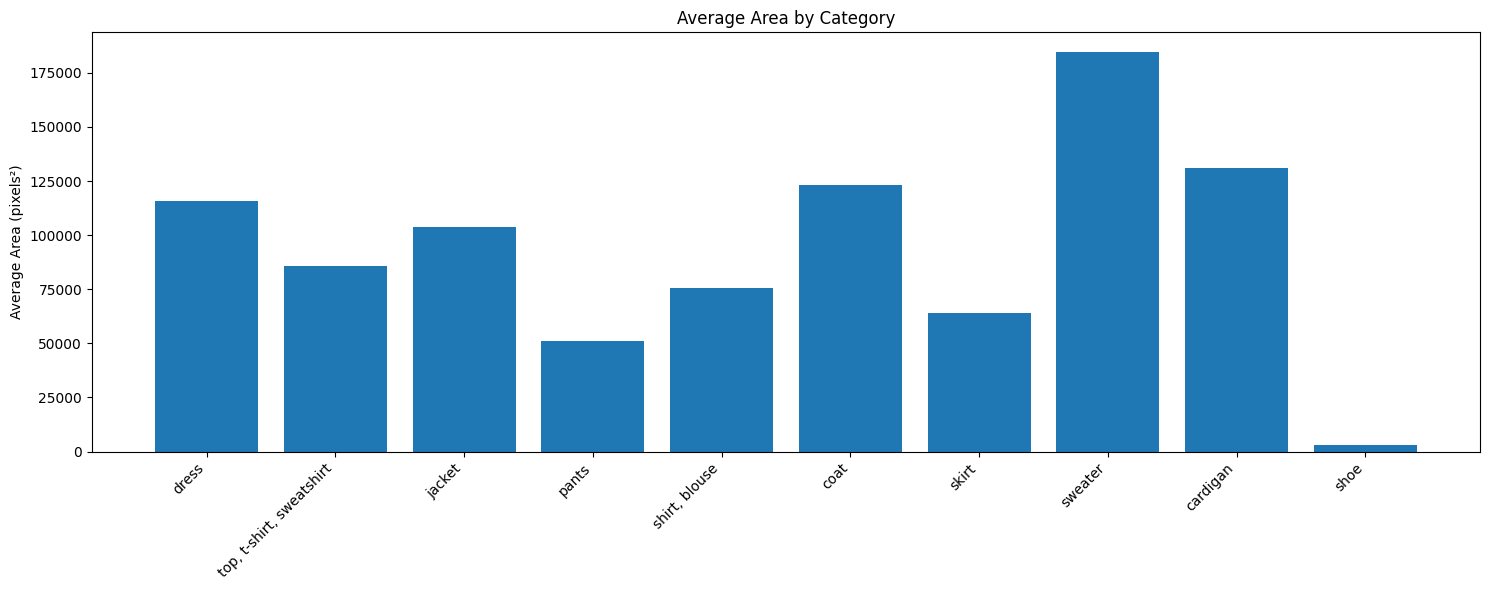

,category,count,avg_area,area_std,is_part,score
2,dress,18739,115943.686589,86340.419977,False,2.172669e+09
15,"top, t-shirt, sweatshirt",16548,85750.852852,128926.134611,False,1.419005e+09
4,sleeve,59448,15583.663588,18526.731578,True,9.264176e+08
13,jacket,7833,103959.595813,117676.258885,False,8.143155e+08
14,pants,12414,51118.224343,45171.438747,False,6.345816e+08
11,"shirt, blouse",6161,75796.631066,120994.894969,False,4.669830e+08
26,coat,3124,123159.927017,112328.455076,False,3.847516e+08
31,skirt,5046,64093.611375,77683.703940,False,3.234164e+08
3,sweater,1494,184520.641232,179741.925712,False,2.756738e+08
36,cardigan,1107,131173.239386,161982.328304,False,1.452088e+08


In [10]:
analyze_categories(dataset)

In [ ]:
def select_category_images(
    dataset_dict,
    categories: List[str],
    n_train: int = 100,
    n_val: int = 20,
    seed: int = 42
) -> Tuple[Dataset, Dataset]:
    """
    Select images containing ALL specified categories for training and validation.
    
    Args:
        dataset_dict: HuggingFace DatasetDict
        categories: List of category names to include
        n_train: Number of training images to select
        n_val: Number of validation images to select
        seed: Random seed for reproducibility
        
    Returns:
        Tuple of (training_dataset, validation_dataset)
    """
    random.seed(seed)
    np.random.seed(seed)
    
    # Access the training split
    dataset = dataset_dict['train']
    
    # Get category IDs from names
    category_ids = {
        name: idx for idx, name in enumerate(
            dataset.features['objects'].feature['category'].names
        )
    }
    
    # Convert input categories to IDs
    target_cat_ids = {category_ids[cat] for cat in categories if cat in category_ids}
    
    # Find images containing ALL target categories
    valid_indices = []
    for idx, item in enumerate(dataset):
        cats_in_image = set(item['objects']['category'])
        # Check if ALL target categories are in this image
        if target_cat_ids.issubset(cats_in_image):
            valid_indices.append(idx)
    
    # Ensure we have enough images
    total_needed = n_train + n_val
    if len(valid_indices) < total_needed:
        raise ValueError(
            f"Not enough images with ALL specified categories. "
            f"Found {len(valid_indices)}, need {total_needed}. "
            f"Try reducing n_train and n_val or selecting fewer categories."
        )
    
    # Shuffle indices
    random.shuffle(valid_indices)
    
    # Split into train and val
    train_indices = valid_indices[:n_train]
    val_indices = valid_indices[n_train:n_train + n_val]
    
    # Create new datasets
    train_dataset = dataset.select(train_indices)
    val_dataset = dataset.select(val_indices)
    
    # Print statistics
    print("\nDataset split statistics:")
    print(f"Total images with all categories: {len(valid_indices)}")
    print(f"Training images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")
    
    # Print category distribution
    print("\nCategory distribution:")
    for split_name, split_data in [("Train", train_dataset), ("Val", val_dataset)]:
        print(f"\n{split_name} split:")
        cat_counts = defaultdict(int)
        for item in split_data:
            for cat_id in item['objects']['category']:
                if cat_id in target_cat_ids:
                    cat_name = dataset.features['objects'].feature['category'].names[cat_id]
                    cat_counts[cat_name] += 1
        
        for cat in categories:
            print(f"{cat}: {cat_counts[cat]} instances")
    
    return train_dataset, val_dataset


In [ ]:
# Trying with fewer categories to find images with all categories
categories_of_interest = [
    "pants",
     "bag, wallet", 
    "shirt, blouse"  # Starting with just two categories as example
]

try:
    train_ds, val_ds = select_category_images(
        dataset,
        categories=categories_of_interest,
        n_train=200,  # Reduced numbers since we need images with ALL categories
        n_val=50
    )
except ValueError as e:
    print(f"Error: {e}")
    print("Try reducing the number of categories or the required images.")

In [ ]:
def visualize_and_save_dataset(
    dataset,
    categories: List[str],
    save_dir: str,
    num_images: int = 5,
    thickness: int = 2,
    font_scale: float = 0.8
) -> None:
    """
    Visualize images with bounding boxes and labels using OpenCV.
    
    Args:
        dataset: HuggingFace dataset split
        categories: List of category names to highlight
        save_dir: Directory to save visualizations
        num_images: Number of images to visualize
        thickness: Line thickness for bounding boxes
        font_scale: Font scale for labels
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get category IDs
    category_ids = {
        name: idx for idx, name in enumerate(
            dataset.features['objects'].feature['category'].names
        )
    }
    target_cat_ids = {category_ids[cat] for cat in categories}
    
    # Create color map for categories (BGR format for OpenCV)
    np.random.seed(42)  # for reproducible colors
    colors = np.random.randint(0, 255, size=(len(categories), 3)).tolist()
    color_map = dict(zip(categories, colors))
    
    # Font for OpenCV
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    # Process specified number of images
    for i in range(min(num_images, len(dataset))):
        try:
            example = dataset[i]
            
            # Convert PIL image to numpy array if necessary
            image = np.array(example['image'])
            
            # Convert to BGR format for OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            objects = example['objects']
            
            # Get image dimensions
            img_height, img_width = image.shape[:2]
            print(f"Processing image {i+1}, shape: {image.shape}")
            
            # Create a copy of the image to draw on
            img_draw = image.copy()
            
            # Draw bounding boxes and labels
            for bbox, cat_id in zip(objects['bbox'], objects['category']):
                if cat_id in target_cat_ids:
                    cat_name = dataset.features['objects'].feature['category'].names[cat_id]
                    
                    # Get bbox coordinates
                    x1, y1, x2, y2 = map(int, bbox)  # Convert to integers for OpenCV
                    
                    # Verify if bbox is within reasonable bounds
                    if (x1 < 0 or y1 < 0 or 
                        x2 > img_width or 
                        y2 > img_height or 
                        x2-x1 <= 0 or y2-y1 <= 0):
                        print(f"Warning: Invalid bbox for {cat_name} in image {i+1}")
                        print(f'Box is {xy},{y1}, {x2}, {y2} for image w {img_width}, {img_height}')
                        continue
                    
                    # Get color for this category
                    color = color_map[cat_name]
                    
                    # Draw rectangle
                    cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, thickness)
                    
                    # Add label with background
                    label = cat_name
                    (label_w, label_h), _ = cv2.getTextSize(label, font, font_scale, thickness)
                    
                    # Draw label background
                    label_y = max(y1 - label_h - 10, 0)  # Keep label above box but within image
                    cv2.rectangle(
                        img_draw,
                        (x, label_y),
                        (x + label_w, label_y + label_h + 10),
                        color,
                        -1  # Filled rectangle
                    )
                    
                    # Draw label text (white)
                    cv2.putText(
                        img_draw,
                        label,
                        (x1, label_y + label_h + 5),
                        font,
                        font_scale,
                        (255, 255, 255),  # White text
                        thickness
                    )
            
            # Add title (black text with white background)
            title = f'Image {i+1}'
            (title_w, title_h), _ = cv2.getTextSize(title, font, 1, thickness)
            
            # Draw title background
            cv2.rectangle(
                img_draw,
                (10, 10),
                (10 + title_w, 10 + title_h + 10),
                (255, 255, 255),
                -1
            )
            
            # Draw title text
            cv2.putText(
                img_draw,
                title,
                (10, 10 + title_h + 5),
                font,
                1,
                (0, 0, 0),  # Black text
                thickness
            )
            
            # Save image
            save_path = os.path.join(save_dir, f'image_{i+1:04d}.jpg')
            cv2.imwrite(save_path, img_draw)
            
            if (i + 1) % 10 == 0:
                print(f"Processed {i+1} images")
                
        except Exception as e:
            print(f"Error processing image {i+1}: {str(e)}")
            import traceback
            print(traceback.format_exc())
            continue
    
    print(f"Completed! Saved {min(num_images, len(dataset))} visualizations to {save_dir}")

In [ ]:
# Visualize and save validation images
print("\nSaving validation set visualizations...")
visualize_and_save_dataset(
    val_ds,
    categories_of_interest,
    num_images=50,
    save_dir='val_visualizations'
)